In [2]:
pip install geopy

     -------------------------------------- 119.8/119.8 kB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 40.3/40.3 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geopandas

     ---------------------------------------- 1.1/1.1 MB 6.7 MB/s eta 0:00:00
     --------------------------------------- 22.0/22.0 MB 16.0 MB/s eta 0:00:00
     ---------------------------------------- 5.1/5.1 MB 27.1 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 28.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [231]:
!pip install keras-tuner

     -------------------------------------- 172.2/172.2 kB 2.6 MB/s eta 0:00:00
     -------------------------------------- 904.2/904.2 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.22.1
    Uninstalling protobuf-4.22.1:
      Successfully uninstalled protobuf-4.22.1


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\HP\\anaconda3\\Lib\\site-packages\\google\\~upb\\_message.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [291]:
import numpy as np
import pandas as pd
import tensorflow as tf
from geopy import distance
import geopandas as gp
import seaborn as sns
import matplotlib as mpl
import datetime as dt
import matplotlib.pyplot as plt

import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report


# Assignment 4 - Simple Neural Networks

For this assigment you'll do a realistic task - predicting fraud from transaction data. 
### Some Things to Note

<ul>
<li> The dataset is imbalanced. See: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data for some ideas
<li> The locations, time, dob all likely aren't super useful on their own, but can be made into something more useful without much code or trouble. Think about how it may be useful to represent them. The data doesn't have missing rows, so this is the main data prep portion. 
<li> With respect to the above, and the other data here, we have a lot of rows of data. That means that we can generally handle data that is reasonably wide...
</ul>

### Deliverables

Your final goal is to produce a function that can be called to classify a transaction:
<ul>
<li> Please submit two .ipynb files - one where you did your work, and another that can use your model to make predictions. 
<li> In that prediction file, please ensure:
    <ul>
    <li> You have a function where I can load a file, and the end result is a classificaiton matrix of your prediction accuracy. 
    <li> You load a trained model. There's no training here. 
    <li> Any data prep stuff that is needed for your data should be built in here. I'm going to run a test file that is the exact same setup as the training data.
    <li> I should be able to open the prediction file, load the test data, and click RUN ALL and things should work. 
    <li> In addition to that, please include a short (~1-2 paragraph) description of what you did. Include anything that was innovative/different as well as a note on:
        <ul>
        <li> Any imbalanced data steps. 
        <li> Treatment of the location and time variables. What did you do to them?
        <li> Model structure (layers/size)
        <li> Any optimization steps included - regularization, dropouts, feature selection, etc...
        </ul>
    </ul>
</ul>

### Grades

The grade breakdown is as follows:

<ul>
<li> Code preduces predictions - 40
<li> Accuracy - 30
<li> Explaination - 20
<li> Balance/variable transformations - 10
</ul>



In [292]:
# Load some data
df = pd.read_csv("https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/fraudTrain.csv.zip")
df.drop(columns={"Unnamed: 0"}, inplace=True)
df.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [293]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
trans_date_trans_time,1296675,1274791,2019-04-22 16:02:01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc_num,1296675.0,NaN,NaN,NaN,417192042079641088.0,1308806447000789248.0,60416207185.0,180042946491150.0,3521417320836166.0,4642255475285942.0,4992346398065154048.0
merchant,1296675,693,fraud_Kilback LLC,4403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,1296675,14,gas_transport,131659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amt,1296675.0,NaN,NaN,NaN,70.351035,160.316039,1.0,9.65,47.52,83.14,28948.9
first,1296675,352,Christopher,26669,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,1296675,481,Smith,28794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,1296675,2,F,709863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
street,1296675,983,0069 Robin Brooks Apt. 695,3123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,1296675,894,Birmingham,5617,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

### Deal with Lat/Lon

We can utilize lat/lon of the home and merchant in a useful way?

Note: I left the section headers in from when I did it. You can remove them if you want. 

In [295]:
#To utilize the latitude and longitude of the home and merchant, we can calculate the distance between them using the geopy package. 
#This can provide useful information about the geographical relationship between the transaction and the cardholder's location. 
#We can create a new feature "distance" which represents the distance between the home and merchant locations.

In [296]:
latlong = gp.GeoDataFrame(df[['lat','long']], geometry=gp.points_from_xy(df['lat'], df['long']))
merchlatlong = gp.GeoDataFrame(df[['merch_lat','merch_long']], geometry=gp.points_from_xy(df['merch_lat'], df['merch_long']))
df['distance'] = latlong['geometry'].distance(merchlatlong['geometry'],align=True)

### Deal with Time

Can we make date/time and the date of birth into something useful?

In [ ]:
#The "trans_date_trans_time" column contains both the transaction date and time. 
#Splitted the column into two separate columns, one for the date and one for the time.
#We can also extract additional features from the transaction date and time, such as the day of the week, the hour of the day, and whether it is a weekend or not. 
#helpful in identifying any patterns related to specific days or times.
#Convert the 'dob' column to datetime format using the 'pd.to_datetime()' method.

In [297]:
# Deal with Time
df['trans_date_trans_time'] = df['trans_date_trans_time'].apply(lambda x: dt.datetime.fromisoformat(str(x)))
df['dob'] = df['dob'].apply(lambda x: dt.datetime.fromisoformat(str(x)))
df['age'] = df['trans_date_trans_time'] - df['dob']

df['age'] = df['age'].apply(lambda x: x.days//365)

### Check Target Balance

Overview:
    Total: 1296675
    Positive: 7506 (0.58% of total)



c:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


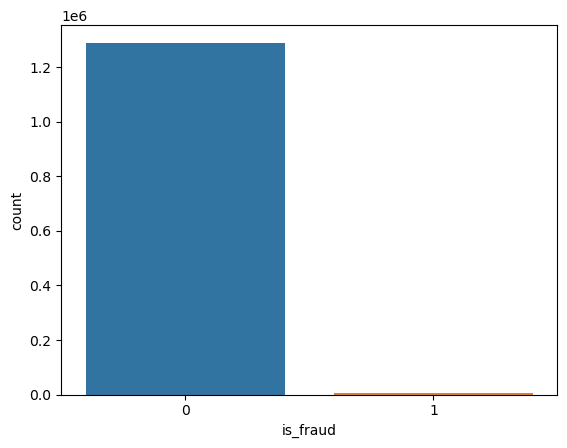

In [298]:
# Check target balance
neg, pos = np.bincount(df['is_fraud'])
total = neg + pos
print('Overview:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

sns.countplot(df['is_fraud'])
plt.show()

In [ ]:
#counted the number of occurrences of each class in the is_fraud column
#printed the counts and proportion of the two classes.
#generated a countplot of the is_fraud column


### Prepare Data


In [38]:
# Drop unnecessary columns
# Split data into features and target

In [299]:
# Drop unnecessary columns
df.drop(columns=['trans_date_trans_time', 'gender', 'merchant', 'first', 'last', 'street', 'city', 'state', 'zip',
                  'job', 'dob', 'trans_num'], inplace=True)

# One-hot encode categorical variables
df = pd.get_dummies(df, drop_first=True)

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   cc_num                   1296675 non-null  int64  
 1   amt                      1296675 non-null  float64
 2   lat                      1296675 non-null  float64
 3   long                     1296675 non-null  float64
 4   city_pop                 1296675 non-null  int64  
 5   unix_time                1296675 non-null  int64  
 6   merch_lat                1296675 non-null  float64
 7   merch_long               1296675 non-null  float64
 8   is_fraud                 1296675 non-null  int64  
 9   distance                 1296675 non-null  float64
 10  age                      1296675 non-null  int64  
 11  category_food_dining     1296675 non-null  uint8  
 12  category_gas_transport   1296675 non-null  uint8  
 13  category_grocery_net     1296675 non-null 

### Split Data

In [301]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)



In [302]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('is_fraud'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('is_fraud'))
test_labels = np.array(test_df.pop('is_fraud'))

In [303]:
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [276]:
scale = StandardScaler()
train_features = scale.fit_transform(train_features)
val_features = scale.fit_transform(val_features)
test_features = scale.fit_transform(test_features)

### Model

In [304]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(72, activation='relu',input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(36, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [305]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


In [306]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model(metrics=METRICS)
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 72)                1728      
                                                                 
 dropout_10 (Dropout)        (None, 72)                0         
                                                                 
 dense_28 (Dense)            (None, 36)                2628      
                                                                 
 dropout_11 (Dropout)        (None, 36)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 37        
                                                                 
Total params: 4,393
Trainable params: 4,393
Non-trainable params: 0
_________________________________________________________________


In [307]:
weight_for_0 = (1 / target_count[0]) * (target_count.sum() / 1.0)
weight_for_1 = (1 / target_count[1]) * (target_count.sum() / 1.7)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.01
Weight for class 1: 101.62


In [308]:
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))


Epoch 1/100
406/406 [==============================] - 4s 7ms/step - loss: 527787358158848.0000 - tp: 60.0000 - fp: 11196.0000 - tn: 813898.0000 - fn: 4718.0000 - accuracy: 0.9808 - precision: 0.0053 - recall: 0.0126 - auc: 0.4995 - prc: 0.0057 - val_loss: 189379687481344.0000 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 206245.0000 - val_fn: 1223.0000 - val_accuracy: 0.9941 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0059
Epoch 2/100
406/406 [==============================] - 2s 6ms/step - loss: 129342671683584.0000 - tp: 40.0000 - fp: 7494.0000 - tn: 817600.0000 - fn: 4738.0000 - accuracy: 0.9853 - precision: 0.0053 - recall: 0.0084 - auc: 0.4996 - prc: 0.0057 - val_loss: 31103305908224.0000 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 206245.0000 - val_fn: 1223.0000 - val_accuracy: 0.9941 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0059
Epoch 3/100
406/406 [==============================] -

In [309]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)
baseline_results = model.evaluate(test_features, test_labels,batch_size=BATCH_SIZE, verbose=0)
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)

127/127 [==============================] - 0s 1ms/step


In [310]:
model.save('Model')

INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets
